# Data Exploration
## Purpose
State the purpose of the notebook.
## Methodology
Quickly describle assumptions and processing steps.
## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- Todo 1;
- Todo 2;

## Results
Describe and comment the most important results.

# Setup
## Library import
We import all the required P
ython libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Utils

**set_lat_lon_attrs**

In [2]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds


**create_ds_mask**

In [3]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

# Data import

## Political boundaries for Spain 
**[Data source](https://gadm.org/download_country_v3.html)**

GADM data (version 3.6).

In [4]:
# Read Political boundaries:
for level in range(3):
    if level == 0:
        spain = gpd.read_file(f'../../datasets/raw/gadm36_ESP_shp/gadm36_ESP_{str(level)}.shp')
        spain['level'] = level
    else:
        gdf = gpd.read_file(f'../../datasets/raw/gadm36_ESP_shp/gadm36_ESP_{str(level)}.shp')
        gdf['level'] = level
        spain = pd.concat([spain, gdf])

In [5]:
spain

,GID_0,NAME_0,geometry,level,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,ESP,Spain,"MULTIPOLYGON (((-18.04792 27.69042, -18.04819 ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ESP,Spain,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",1,ESP.1_1,Andalucía,Andalousie|Andaluc¡a|Andalusien|Andaluzia,None,Comunidad Autónoma,Autonomous Community,01,ES.AN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ESP,Spain,"POLYGON ((0.02648 40.69497, 0.02688 40.70039, ...",1,ESP.2_1,Aragón,Aragão|Aragó|Aragón|Aragona|Aragonien,None,Comunidad Autónoma,Autonomous Community,15,ES.AR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ESP,Spain,"MULTIPOLYGON (((-3.90653 43.47792, -3.90653 43...",1,ESP.3_1,Cantabria,Cantàbria|Cantábria|Cantabrie|Kantabrien,None,Comunidad Autónoma,Autonomous Community,06,ES.CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ESP,Spain,"MULTIPOLYGON (((-3.37095 40.62496, -3.38198 40...",1,ESP.4_1,Castilla-La Mancha,Castela-La Mancha|Castela-Mancha|Castella-la M...,None,Comunidad Autónoma,Autonomous Community,08,ES.CM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,ESP,Spain,"POLYGON ((-3.13116 42.75807, -3.14786 42.75668...",2,ESP.16_1,País Vasco,NaN,None,NaN,NaN,NaN,NaN,ESP.16.1_1,Álava,Araba,None,Provincia,Province,01,ES.PV.AA
48,ESP,Spain,"POLYGON ((-2.59676 42.97596, -2.60264 42.98222...",2,ESP.16_1,País Vasco,NaN,None,NaN,NaN,NaN,NaN,ESP.16.2_1,Guipúzcoa,None,None,Provincia,Province,20,ES.PV.GP
49,ESP,Spain,"MULTIPOLYGON (((-2.49458 43.36819, -2.49458 43...",2,ESP.16_1,País Vasco,NaN,None,NaN,NaN,NaN,NaN,ESP.16.3_1,Vizcaya,None,None,Provincia,Province,48,ES.PV.VZ
50,ESP,Spain,"MULTIPOLYGON (((-6.03181 43.59125, -6.03181 43...",2,ESP.17_1,Principado de Asturias,NaN,None,NaN,NaN,NaN,NaN,ESP.17.1_1,Asturias,None,None,Provincia,Province,33,ES.AS.AS


<AxesSubplot:>

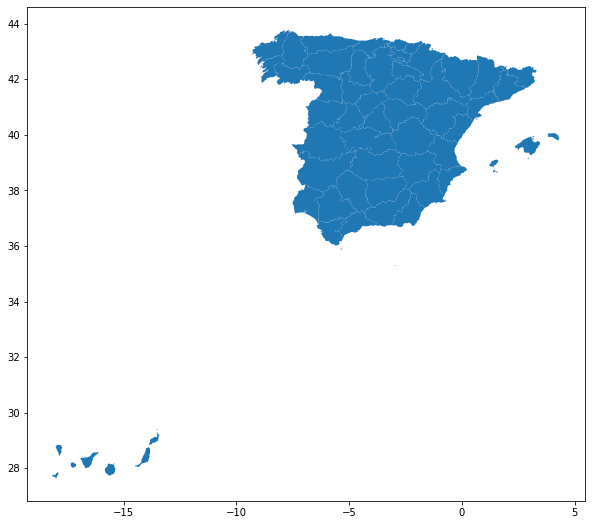

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
spain[spain['level'] == 2].plot(ax=ax)

## Fire danger indicators for Europe 
**[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview)**

The dataset presents projections of fire danger indicators for Europe based upon the Canadian Fire Weather Index System (FWI) under future climate conditions. The FWI is a meteorologically based index used worldwide to estimate the fire danger and is implemented in the Global ECMWF Fire Forecasting model (GEFF).

**Variables:**
- **Seasonal fire weather index:** 
The mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. The higher the index value, the more favorable the meteorological conditions to trigger a wildfire are.

**Read data**

In [7]:
data_dir = '../../datasets/raw/seasonal-fire-weather-index/'
for n, file in enumerate(os.listdir(data_dir)):
    # convert to Dataset and concatenate by time
    if n == 0:
        ds_fire = xr.open_dataset(data_dir+file, engine="netcdf4")
    else:
        ds = xr.open_dataset(data_dir+file, engine="netcdf4")
        ds_fire = xr.concat([ds_fire, ds], dim='time')

In [8]:
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 424, rlat: 412, time: 78, bnds: 2)
Coordinates:
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time_bnds      (time, bnds) datetime64[ns] 2020-11-01 ... 2098-10-31T23:5...
    fwi-mean-jjas  (time, rlat, rlon) float64 33.45 32.92 34.72 ... 1.721 1.813
Attributes: (12/13)
    creation_date:  2019-06-19-T09:24:05Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Multidimensional Coordinates**

The data will derive from a numerical model in which the poles of the model's coordinate system (`logical coordinates`) differ from the earth's true poles (`physical coordinates`). This is typically done when running limited area models, in order to keep the poles as far away as possible from the area that is being modelled. This allows the model's resolution to be roughly uniform over the model domain, as the coordinate system is then approximately cartesian and avoids issues where the meridians converge close to the poles.

In our dataset, the `logical coordinates` are `rlon` and `rlat`, while the physical coordinates are `lon` and `lat`, which represent the latitudes and longitude of the data.

In [9]:
print(ds_fire.rlon.attrs)
print(ds_fire.rlat.attrs)

{'standard_name': 'grid_longitude', 'long_name': 'longitude in rotated pole grid', 'units': 'degrees', 'axis': 'X'}
{'standard_name': 'grid_latitude', 'long_name': 'latitude in rotated pole grid', 'units': 'degrees', 'axis': 'Y'}


In [10]:
print(ds_fire.lon.attrs)
print(ds_fire.lat.attrs)

{'standard_name': 'longitude', 'long_name': 'longitude', 'units': 'degrees_east'}
{'standard_name': 'latitude', 'long_name': 'latitude', 'units': 'degrees_north'}


**Display data**

Xarray provides [several ways](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html) to plot and analyze such datasets.

If we try to plot the data variable `fwi-mean-jjas`, by default we get the logical coordinates.

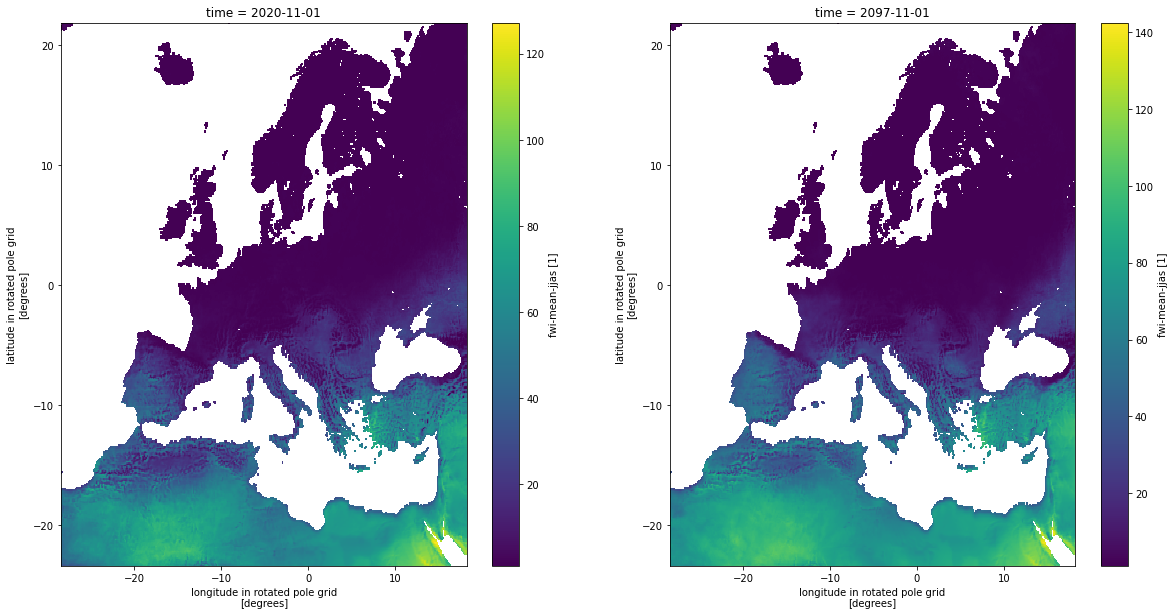

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
ds_fire['fwi-mean-jjas'].isel(time=0).plot(ax=axs[0])
ds_fire['fwi-mean-jjas'].isel(time=77).plot(ax=axs[1])

In order to visualize the data on a conventional latitude-longitude grid, we can take advantage of xarray’s ability to apply [cartopy](http://scitools.org.uk/cartopy/index.html) map projections.

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


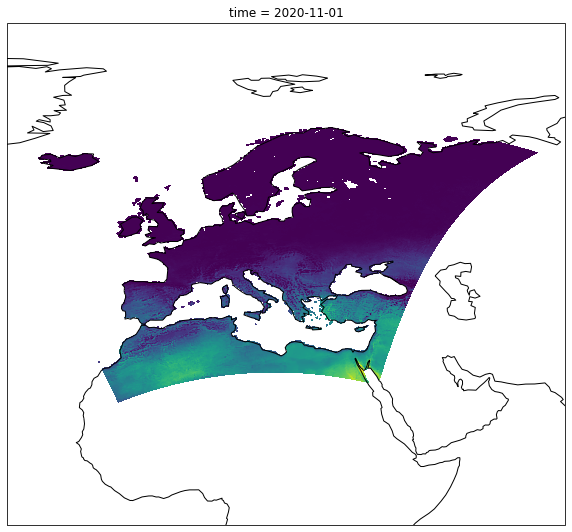

In [12]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_fire['fwi-mean-jjas'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);
ax.set_xlim([-30,70]);

### Rasterize vector data

Create the data mask by rasterizing the vector data

In [13]:
gdf = spain[spain['level'] == 0].copy()
da_mask = create_ds_mask(gdf, ds_fire, name='mask', lon_name='lon', lat_name='lat')

The mean ds cell area is 0.000114 deg.



/tmp/ipykernel_65/4059690151.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 1 potential geometries, of which 1 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 1
Number of geoms: 1
Number of ints in mask: 1


Add mask as a new variable into the xarray.Dataset

In [14]:
ds_fire['mask'] = da_mask
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 424, rlat: 412, time: 78, bnds: 2)
Coordinates:
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time_bnds      (time, bnds) datetime64[ns] 2020-11-01 ... 2098-10-31T23:5...
    fwi-mean-jjas  (time, rlat, rlon) float64 33.45 32.92 34.72 ... 1.721 1.813
    mask           (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    creation_date:  2019-06-19-T09:24:05Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Display values for Spain**

In [15]:
index = 0
xmin, ymin, xmax, ymax = gdf.iloc[index]['geometry'].bounds
ds_fire_spain = ds_fire['fwi-mean-jjas'].where(ds_fire.mask == index).copy()

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


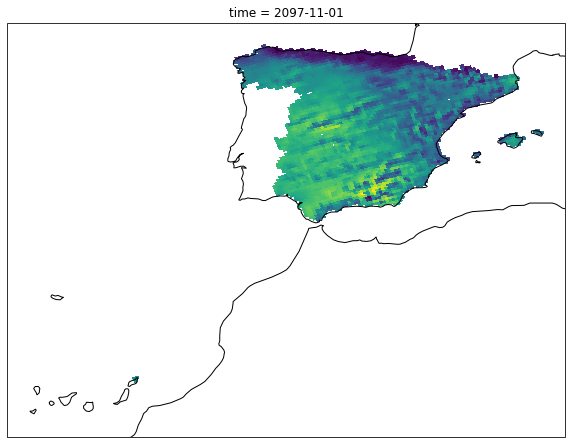

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_fire_spain.isel(time=77).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([ymin-1, ymax+1]);
ax.set_xlim([xmin-1, xmax+1]);

**Compute mean value over time**

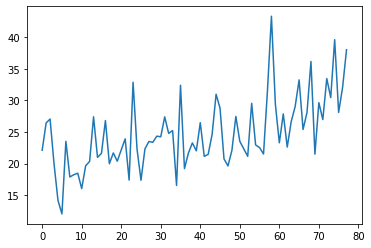

In [17]:
plt.plot(ds_fire_spain.where(ds_fire.mask == index).mean(['rlon', 'rlat']).values)